 **Damage Mechanics**
==================================================================================================
Work 1 - Isotropic plasticity with linear hardening
==================

_by Guilherme Jenovencio, M. Sc._

 
Model Description:
----------------

-  Additive decomposition of the strain tensor:

$$\varepsilon = \varepsilon^e + \varepsilon^p \tag{1} $$                  

- Definition of the Free-energy function 

$$\Psi(\varepsilon^e,r) =   \Psi^e(\varepsilon^e) + \Psi^p(r) \tag{2} $$  

Where _r_ is the accumulated platic strain: $r = \int_{0}^{t}\sqrt{\frac{2}{3}}||{\dot{\varepsilon^p}}||dt  $.

- Constitutive equation for $\sigma$ and thermodynamic force R 

$$\sigma =  \frac{\partial \Psi^e}{\partial \varepsilon^e} \tag{3} $$  
 
$$R =  \frac{\partial \Psi^p}{\partial r} \tag{4} $$   

- Yield function 

$$f =  f(\sigma,R) \tag{5} $$   

-  Dissipation potential 

$$g =  f(\sigma,R) \tag{6} $$   

- Plastic flow rule and hardening law 

$$\dot{\varepsilon^p} = \dot{\lambda}\frac{\partial f}{\partial \sigma} = \dot{\lambda}\mathbf{N} \tag{7} $$   

$$\dot{r} = -\dot{\lambda}\frac{\partial f}{\partial R} = \dot{\lambda}\mathbf{H}  \tag{8} $$   


- Loading/unloading criterion 

$$f(\sigma,R) \leq 0 \tag{9} $$   

$$\dot{\lambda} \geq 0 \tag{10} $$

$$f(\sigma,R)\dot{\lambda} = 0 \tag{11}$$  

-  Consistency condition under plastic yielding $\dot{\lambda}\ne0$

$$\dot{f(\sigma,R)}\dot{\lambda} = 0 \tag{12}$$  


Selection of a free energy potencial and the Yield function:

- Free energy potencial

$$\Psi^e(\varepsilon^e) = + \frac{1}{2}\mathbf{D}\varepsilon^e.\varepsilon^e \tag{13} $$  

$$\Psi^p(r) = + \frac{1}{2}Hr^2 \tag{14} $$  

Where **D** is a forth order tensor and *H* is a scalar parameter  both are material properties. 

- Yield function

$$f =  f(\sigma,R) = \sigma_{eq}^D - \sigma_y(r) \tag{15} $$ 

Where 

$$ \sigma = \sigma^D + \frac{tr(\sigma)}{3}I = \sigma^D + pI \tag{16} $$

$$ \sigma_{eq}^D = \bigg(\frac{3}{2} \sigma^D.\sigma^D \bigg)^\frac{1}{2} \tag{17} $$

$$\sigma_y(r) = \sigma_{yo}(r) +R(r) = \sigma_{yo}(r) + Hr \tag{18} $$ 



**Elastic predictor / Return-Mapping Algorithm**
===============================================

Initial Constitutive Value problem

Let's say the total deformation tensor at the current time $\varepsilon_{n+1}$ and the state variable at the previous time $\alpha_n$ are known, then we will determine the stress and the state variable vector ($\sigma_{n+1}$, $\alpha_{n+1}$) at the current time, where :



$$\alpha = \{r ,\varepsilon^p \} $$


Integration (7) implicity we get the folowwing expression for the plastic strain increment:

$$ \Delta{\varepsilon^p} = \Delta{\lambda}\mathbf{N} \tag{19} $$  

where $\Delta{\lambda}$ is the plastic multiplier increment.

- Elastic trial.


Firstly, we assume that the strain increment $\Delta{\varepsilon}$ is elastic  , which also means $\Delta{\lambda}=0$.
Then we set the inicial conditions as:

$$\alpha_{n+1}^{trial} = \alpha_{n} \tag{20} $$


$$ \varepsilon_{n+1}^{etrial} = \varepsilon_{n+1} - \varepsilon_n^p \tag{21}  $$

The deviatoric and volumetric split can be aplied on (21):

$$ \varepsilon_{n+1}^{etrial} = \hat{\varepsilon}_{n+1}^{etrial} + {\varepsilon}_{vol [n+1]}^{etrial} \tag{22} $$

Where ${\varepsilon}_{vol [n+1]}^{etrial} = \frac{1}{3}tr(\varepsilon_{n+1}^{etrial})I $

Then, (16) can be written in terms of the trial strain as:

$$ p_{n+1}^{trial} = K{\varepsilon}_{vol [n+1]}^{etrial} \tag{23}$$

$$ \sigma_{n+1}^{Dtrial} = 2G\hat{\varepsilon}_{n+1}^{etrial} \tag{24} $$


Then, the von-Mises stress (17) can be writen as:

$$ \sigma_{eq}^{Dtrial} = \sqrt{\frac{3}{2} \sigma_{n+1}^{Dtrial}.\sigma_{n+1}^{Dtrial}} \tag{25} $$


The yield function can be checked with (25) and (15):

$$f^{trial}  = \sigma_{eq}^{Dtrial} - (\sigma_{yo}+Hr_n) <0 \tag{26} $$ 

if (26) is true then the stress is inside the yield function, otherwise the plastic multiplier increment should be greater then zero and the return-mapping algorithm must be solved. 

Implementation of Elastic trial
=========================


In [114]:
import numpy as np
import matplotlib.pyplot as plt

def matprop():
    ''' This fucntion will return the  material properties
    '''
    E = 200.0e3 # Elastic modulus in MPa
    v = 0.3 # poisson ration
    G = E/(2.*(1. + v))  # Shear modulus
    K = E/(3.*(1. - 2.*v)) # Bulk modulus
    
    sigmayo = 200. # initial yield stress in MPa
    H = 5.0e3 # Hardening modulus in MPa
    return E,v,G,K,sigmayo,H
    
def initState(rn=0,epn=np.zeros((3,3))):
    ''' This function will return the initial internal variables
    '''
    rn = rn # acculumated plastic strain
    epn = epn # plastic strain at n
    
    return rn, epn

def dhdec(S):
    ''' deviatoric and hidrostatic decomposition
    given a tensor  S split in Sdev and svol*I
    where Sdev is de deviatoric part
    and Svol is the 
    '''
    svol = np.trace(S)
    I = np.eye(3,3)
    Sdev = S - (svol/3.0)*I
    
    return Sdev, svol

def yieldfunc(sdev,rn):
    ''' this is the yield function
        sdev  is de deviatoric stress
        rn is the accumulated plastic strain
    '''
    
    E,v,G,K,sigmayo,H = matprop()
    
    vm = np.sqrt(3.0/2.0)*np.linalg.norm(sdev)
    
    Rtriel = sigmayo + H*rn
    f =  vm - Rtriel
    #print('rn = %f' %rn)
    #print('vM = %f' %vm)
    #print('f = %f' %f)
    return f
    
def elasticTrial(En1,an):
    '''This function the get the elastic strain at n + 1 and 
    the state variable in nand check is the stress is inside the yield surface.
    ''' 
    # getting material properties
    E,v,G,K,sigmayo,H = matprop()
    
    rn, epn = an
    # elastic triel
    eetrial = En1 - epn #elastic triel
    eetrieldev, eetrialvol = dhdec(eetrial)
    
    sdevtrial = 2.0*G*eetrieldev # deviatoric stress
    ptrial = K*eetrialvol
    
    f = yieldfunc(sdevtrial,rn)

    if f<0:
        return True,f,sdevtrial,ptrial
    else: 
        return False,f,sdevtrial,ptrial
    
#----------------------------------------------------------------------------
# Test elasticTrial function

inc =0.0001 # displacement increment   
n = 14      # number of displaciment increment

exx = n*inc
eyy = -n*0.5*inc
ezz = eyy

En1 = np.matrix([ [exx ,  0.    ,   0.   ], 
                  [0.  , eyy    ,   0.   ],
                  [0.  ,  0.    ,    ezz ] ])


p = 0. # proportion of plastic strain
epn = p*En1


# getting the internal variable
rn = np.sqrt(3.0*np.tensordot(epn,epn)/2.0)
an = initState(rn,epn)

iselastic,f,sdevtrial,ptrial = elasticTrial(En1,an)

if iselastic:
    print("The strain increment is pure elastic")
else:    
    print("The strain increment is NOT pure elastic. The plastic multiplier should be greater than 0." +
          "\nGo to Return Mapping algorithm.")


The strain increment is NOT pure elastic. The plastic multiplier should be greater than 0.
Go to Return Mapping algorithm.


Return-Mapping Algorithm
=============================================
When the stress state lies on the yield surface the material is said to have reached its yield point and the material is said to have a plastic increment greated then zero. Using the elastic trial state deﬁnition, we write the algebraic system equations as

$$ \varepsilon_{n+1}^e - \varepsilon_{n+1}^{etrial}  + \Delta\lambda\mathbf{N}_{n+1} = \mathbf{0}  $$

$$ \alpha_{n+1} - \alpha_{n+1}^{trial}  + \Delta\lambda\mathbf{H}_{n+1} = \mathbf{0}  \tag{27}$$

$$ f = 0  $$

Considering the initial state variables as (20)  the system (27) for the particular chosen free Enegery potencial and Yield function becames,

$$ \varepsilon_{n+1}^e - \varepsilon_{n+1}^{etrial}  + \Delta\lambda\sqrt{\frac{3}{2}}\frac{\sigma_{n+1}^D}{||\sigma_{n+1}^D||} = \mathbf{0}  $$



$$ \varepsilon_{n+1}^p - \varepsilon_{n}^p  - \Delta\lambda\sqrt{\frac{3}{2}}\frac{\sigma_{n+1}^D}{||\sigma_{n+1}^D||} = \mathbf{0}  \tag{28} $$

$$ r_{n+1} - r_{n}  - \Delta\lambda = 0  $$

$$ \sigma_{eq}^{D} - \sigma_{yo} - Hr_{n+1} = 0  $$


It is possible to show that the trial and updated deviatoric stress are proportional, which implies that


$$ \frac{\sigma_{n+1}^D}{||\sigma_{n+1}^D||} = \frac{\sigma_{n+1}^{Dtrial}}{||\sigma_{n+1}^{Dtrial}||} \tag{29}   $$

Where 

$$ \sigma_{n+1}^D = 2G\hat{\varepsilon}_{n+1}^e \tag{30} $$ 

and

$$ \hat{\varepsilon}_{n+1}^e = \varepsilon_{n+1}^e - \frac{tr(\varepsilon_{n+1}^e)}{3}  \tag{31} $$

Using (29), (30) and (31) we can rearange the system (28) in order to depends only on $\varepsilon_{n+1}^{etrial}$ and $\Delta\lambda$. 

$$ \sigma_{eq}^{D}(\hat{\varepsilon}_{n+1}^{etrial}) - \sigma_{yo} - Hr_{n}  - H\Delta\lambda = 0  \tag{32} $$

Where

$$ \sigma_{eq}^{D}(\hat{\varepsilon}_{n+1}^{etrial}) = \sqrt{\frac{3}{2} \sigma^{D}(\hat{\varepsilon}_{n+1}^{etrial}).\sigma^{D}(\hat{\varepsilon}_{n+1}^{etrial})} \tag{33} $$

and 

$$\sigma^{D}(\hat{\varepsilon}_{n+1}^{etrial}) =  \sigma_{n+1}^{Dtrial} - \frac{3\Delta\lambda G}{\sigma_{eq}^{Dtrial}}\sigma_{n+1}^{Dtrial} = \left( 1 - \frac{3\Delta\lambda G}{\sigma_{eq}^{Dtrial}}\right) \sigma_{n+1}^{Dtrial} \tag{34} $$

Simplifying equation (32) with (33) and (34) we have a linear expression for the plastic multiplies increment $\Delta\lambda$.

$$ F( \Delta\lambda (\varepsilon_{n+1}^{etrial}),\varepsilon_{n+1}^{etrial}) = \sigma_{n+1}^{Dtrial} - 3\Delta\lambda G - \sigma_{yo} - Hr_{n}  - H\Delta\lambda = 0  \tag{35} $$

Which can be rearranged to solved the plastic multiplier increment in a closed form


$$ \Delta\lambda = \frac{\sigma_{n+1}^{Dtrial} - \sigma_{yo} - Hr_{n}}{3G + H}  \tag{36} $$


With equation (36) all state variables can be updated.

$$ p_{n+1} = p_{n+1}^{trial} \tag{37} $$

$$ \sigma_{n+1}^D = \left( 1 - \frac{3\Delta\lambda G}{\sigma_{eq}^{Dtrial}}\right) \sigma_{n+1}^{Dtrial} \tag{38} $$ 

$$ \sigma_{n+1} = \sigma_{n+1}^D + p_{n+1}I   \tag{39} $$ 

$$ \varepsilon_{n+1}^{p} = \varepsilon_{n}^p  - \Delta\lambda\sqrt{\frac{3}{2}}\frac{\sigma_{n+1}^D}{||\sigma_{n+1}^D||} \tag{40} $$

$$ r_{n+1} = r_{n} + \Delta\lambda  \tag{41} $$ 



Implementation of Return-Mapping Algorithm for Linear Isotropic Hardening
=========================================================================

In [115]:
def returnMapping(ftrial,sdevtrial,ptrial,an):
    
    E,v,G,K,sigmayo,H = matprop()
    rn, epn = an
    
    plasticMult = ftrial/(3.0*G + H)
    #print("plasticMult = %f" %plasticMult)
    
    pn1 = ptrial
    seqtrial = np.sqrt(3.0/2.0)*np.linalg.norm(sdevtrial)
    #print("seqtrial = %f " %seqtrial)
    sdev = (1.0 - 3.0*G*plasticMult/seqtrial)*sdevtrial
    stressn1 = sdev + pn1*np.eye(3,3)
    epn1 = epn +  plasticMult*np.sqrt(3.0/2.0)*sdevtrial/np.linalg.norm(sdevtrial)
    rn1  = rn + plasticMult  
    
    an1 = rn1, epn1
    return stressn1, an1, plasticMult

# call Elastic triel 
iselastic,ftrial,sdevtrial,ptrial = elasticTrial(En1,an) # iselastic boolen variable, f = is the triel yield function
print("Is the increment pure elastic = %r" %iselastic)
#print("ftriel = %f" %ftrial)
#print("Deviatoric Stress = ")
#print(sdevtrial)
#print("Hidrostatic pressure = %f" %ptrial)

if iselastic:
    stressn1 = sdevtrial + ptrial*np.eye(3,3)
    an1 = an
else:
    print("Calling Return-Mapping algorithm \n")
    stressn1,an1, plasticMult = returnMapping(ftrial,sdevtrial,ptrial,an)

#extract intern variables    
rn1, epn1 = an1

#Print state variable
print("Updated Stress = "  )
print(stressn1 )

print("\nUpdated Accumulated plastic strain = %f \n" %rn1  )

print("Updated Plastic Strain tensor = "  )
print(epn1)

    
   




Is the increment pure elastic = False
Calling Return-Mapping algorithm 

Updated Stress = 
[[ 135.07340946    0.            0.        ]
 [   0.          -67.53670473    0.        ]
 [   0.            0.          -67.53670473]]

Updated Accumulated plastic strain = 0.000522 

Updated Plastic Strain tensor = 
[[ 0.00052202  0.          0.        ]
 [ 0.         -0.00026101  0.        ]
 [ 0.          0.         -0.00026101]]


Consistent Tangent Modulus
==========================================================

In order to implement a material model in a Finite Element context the updated stress $\sigma_{n+1}$ delivered by (39) is required to assemble the element internal force vector

$$f_e^{int} = \sum_{i=1}^{n_{gaussp}}j_iw_i\mathbf{B}_i^T\sigma_{n+1} \tag{42}$$


The consistent tangent modulus 

$$ \mathbf{D} = \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}} \tag{43} $$

is also required in order to evaluate the element stiffness

$$ \mathbf{K}_T^e = \sum_{i=1}^{n_{gaussp}}w_ij_i\mathbf{B}_i^T\mathbf{D}\mathbf{B}_i \tag{44} $$

Let us rewrite equation (39) in term of $\varepsilon_{n+1}^{etrial}$

$$ \sigma_{n+1} = \left( 1 - \frac{3\Delta\lambda G}{\sigma_{eq}^{Dtrial}}\right) 2GI_d\varepsilon_{n+1}^{etrial} + K \frac{tr(\varepsilon_{n+1}^{etrial})}{3}I   \tag{45} $$ 

Where $I_d$ is the deviatoric project defined as 

$ \hat{\varepsilon}_{n+1}^{etrial} = I_d\varepsilon_{n+1}^{etrial} \tag{46}$

Rearraging (49)

$$ \sigma_{n+1} = \Bigg[ 2GI_d\varepsilon_{n+1}^{etrial} + K \frac{tr(\varepsilon_{n+1}^{etrial})}{3}I \Bigg]     - \frac{6\Delta\lambda G^2}{\sigma_{eq}^{Dtrial}}I_d\varepsilon_{n+1}^{etrial}  \tag{47} $$ 


Note that the expression inside the brackets is equal to the generalized Hooke's law $\sigma_{n+1} = \mathbf{D}\varepsilon_{n+1}^{etrial}$, then (47) becomes

$$ \sigma_{n+1} =  \Bigg[\mathbf{D} -\frac{6\Delta\lambda G^2}{\sigma_{eq}^{Dtrial}}I_d\Bigg]\varepsilon_{n+1}^{etrial}  \tag{48} $$ 

Using the chain rule in (43)

$$ \mathbf{D} = \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}^{etriel}}\frac{\partial \varepsilon_{n+1}^{etriel}}{\partial \varepsilon_{n+1}} \tag{49} $$

However differentiation on (21) gives $\frac{\partial \varepsilon_{n+1}^{etriel}}{\partial \varepsilon_{n+1}} = I $, which implies 

$$ \mathbf{D} = \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}} = \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}^{etrial}} \tag{50}   $$

Then, in order to calculate the consistent tangent modulus, we may derive (48), however the $\sigma_{eq}^{Dtrial}$ and $\Delta\lambda$ are both function of $\varepsilon_{n+1}^{etrial}$ definded by (25) and (36) respectively. Applying a tensor differentiation on (48) gives

$$ \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}^{etrial}} =  \mathbf{D} -\frac{6\Delta\lambda G^2}{\sigma_{eq}^{Dtrial}}I_d - \frac{6G^2}{\sigma_{eq}^{Dtrial}}\hat{\varepsilon}_{n+1}^{etrial}\otimes\frac{\partial \Delta\lambda}{\partial \varepsilon_{n+1}^{etrial}} + \frac{\Delta\lambda6G^2}{(\sigma_{eq}^{Dtrial})^2}\hat{\varepsilon}_{n+1}^{etrial}\otimes\frac{\partial \sigma_{eq}^{Dtrial}}{\partial \varepsilon_{n+1}^{etrial}}  \tag{51} $$


Where the $\frac{\partial \sigma_{eq}^{Dtrial}}{\varepsilon_{n+1}^{etrial}}$ may be calculate by differentiate (25)

$$ \frac{\partial \sigma_{eq}^{Dtrial}}{\partial\varepsilon_{n+1}^{etrial}} = 2G\sqrt{\frac{3}{2}} \frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||}I_d  = 2G\sqrt{\frac{3}{2}} N_{n+1} \tag{52} $$

Where the identities $ N_{n+1} = \frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||} $ 
and  $ \hat{\varepsilon}_{n+1}^{etrial} = I_d\hat{\varepsilon}_{n+1}^{etrial}$ were used. The  $\frac{\partial \Delta\lambda}{\varepsilon_{n+1}^{etrial}}$ term may be obtaned by differentiate (36)


$$ \frac{\partial \Delta\lambda}{\partial \varepsilon_{n+1}^{etrial}} = \frac{1}{3G + H}\frac{\partial \sigma_{eq}^{Dtrial}}{\partial\varepsilon_{n+1}^{etrial}} = \frac{2G}{3G + H}\sqrt{\frac{3}{2}}N_{n+1}  \tag{53}$$

Then, when the $\Delta\lambda \geq 0$ the consitent tangent modulus may be expressed in the close form substituting (52) and (53) in (51):

$$ \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}^{etrial}} =  \mathbf{D} -\frac{6\Delta\lambda G^2}{\sigma_{eq}^{Dtrial}}I_d 
- \frac{6G^2}{3G+H}\bigg( \frac{2G \hat{\varepsilon}_{n+1}^{etrial}}{\sigma_{eq}^{Dtrial}}\bigg) \otimes
\sqrt{\frac{3}{2}} \frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||}
+ \frac{6G^2\Delta\lambda}{\sigma_{eq}^{Dtrial}}
\bigg(\frac{2G\hat{\varepsilon}_{n+1}^{etrial}}{\sigma_{eq}^{Dtrial}}\bigg)
\otimes
\sqrt{\frac{3}{2}}\frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||}  \tag{54} $$

Note that

$$\frac{2G\hat{\varepsilon}_{n+1}^{etrial}}{\sigma_{eq}^{Dtrial}} =
\frac{2G\hat{\varepsilon}_{n+1}^{etrial}}
{\sqrt{\frac{3}{2}} 2G ||\varepsilon_{n+1}^{etrial}|| } =
\sqrt{\frac{2}{3}}
\frac{\hat{\varepsilon}_{n+1}^{etrial}}
{||\varepsilon_{n+1}^{etrial}||} \tag{55} $$ 

Finally, replacing (55) in (54) gives:

$$ \frac{\partial \sigma_{n+1}}{\partial \varepsilon_{n+1}^{etrial}} =  \mathbf{D} -\frac{6\Delta\lambda G^2}{\sigma_{eq}^{Dtrial}}I_d + 
6G^2\Bigg[ \frac{\Delta\lambda}{\sigma_{eq}^{Dtrial}} - \frac{1}{3G+H}   \Bigg]
\frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||}
\otimes
\frac{\hat{\varepsilon}_{n+1}^{etrial}}{||\hat{\varepsilon}_{n+1}^{etrial}||}
\tag{56} $$
 
Implementation of the Consistent Tangent Modulus
========================================================== 


In [116]:
def CTM(eetrial,plasticMult,sdevtrial):
    ''' This function evaluates the updated Consistent Tangent Modulus Dn1
    '''
    E,v,G,K,sigmayo,H = matprop()
    
    I = np.eye(3,3) # Identity matrix
    I4 = np.einsum("ij,kl->ijkl",I,I) # 3d second-rank identity tensor
    Is4 = 0.5*( np.einsum("ik,jl->ijkl",I,I) 
              + np.einsum("il,jk->ijkl",I,I) )  # 3d symmetric part of the fourth-rank identity tensor
    Id =  Is4 - I4/3.0  # deviatoric projection
    
    D = 2.0*G*Is4 +K*I4 # Elastic forth order tensor
    
    if iselastic:
        Dn1 = D
        return Dn1
    
    else:
        eetrieldev, eetrialvol = dhdec(eetrial) # calling deviatoric and volumetric decomposition
        seqtrial = np.sqrt(3.0/2.0)*np.linalg.norm(sdevtrial) # von-Mises trial
        
        N = eetrieldev/np.linalg.norm(eetrieldev)  # flow direction edev/||edev||
        N4 = np.einsum("ij,kl->ijkl",N,N) # forth order tensor N(i,j)*N(k,l)
        # the plastic multiplies is greater than 0
        Dn1 = D - (6.0*plasticMult*G*G/seqtrial)*Id + (6.0*G*G)*(plasticMult/seqtrial-1.0/(3.0*G + H))*N4
        return Dn1

def FourthTen2Voigt(D4):
    ''' This function converts fourth order symmetric tensor to Voigt notation
    '''
    indexMap = {'0':[0,0],'1':[1,1],'2':[2,2],'3':[1,2],'4':[0,2],'5':[0,1]} # Dictionary of index mapping
                                                                            # python index start from 0
    D66 = np.zeros([6,6])
    for i in range(6):
        for j in range(6):
            ijkl = indexMap[str(i)] + indexMap[str(j)] 
            #print(ijkl)
            D66[i,j] = D4[tuple(ijkl)]
    
    return D66

def printMatrixE(a):
   '''This function prints a matrix a
   '''
   print('------------------------------------------------------------------')
   rows = a.shape[0]
   cols = a.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print("%10.2f" %a[i,j]),
      print
   print      
   print('------------------------------------------------------------------')
#--------------------------------------------------------------------------------------------------------
# testing CTM function
eetrial = En1 - epn #elastic triel
eetrieldev, eetrialvol = dhdec(eetrial) # deviatoric and volumetric decomposition
Dn1 = CTM(eetrial,plasticMult,sdevtrial)
#print(Dn1)
D66 = FourthTen2Voigt(Dn1)
print("updated Consistent Tangent Modulus using Voigt notation [MPa] \n")
printMatrixE(D66)

    

updated Consistent Tangent Modulus using Voigt notation [MPa] 

------------------------------------------------------------------
 220123.81  216861.17  216861.17       0.00       0.00       0.00
 216861.17  266733.00  170251.99       0.00       0.00       0.00
 216861.17  170251.99  266733.00       0.00       0.00       0.00
      0.00       0.00       0.00   48240.50       0.00       0.00
      0.00       0.00       0.00       0.00   48240.50       0.00
      0.00       0.00       0.00       0.00       0.00   48240.50

------------------------------------------------------------------


Isochoric Strain Implementation
======================================

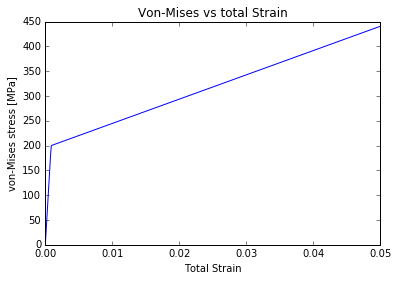

In [119]:
%matplotlib inline
#----------------------------------------------------------------------------
# Isochoric Strain 
# initializing intern variables
rn = 0.0 # accumulated plastic strain
epn = np.zeros([3,3])
an = initState(rn,epn)

inc =0.0001 # displacement increment   
n = 500      # number of increaments

s11 = [] # list of von-Mises stress
e11 = [] # list of strain 11
for i in range(n):

    exx = i*inc
    eyy = -i*0.5*inc
    ezz = eyy

    En1 = np.matrix([ [exx ,  0.    ,   0.   ], 
                      [0.  , eyy    ,   0.   ],
                      [0.  ,  0.    ,    ezz ] ])
    

    iselastic,ftrial,sdevtrial,ptrial = elasticTrial(En1,an)

    if iselastic:
        stressn1 = sdevtrial + ptrial*np.eye(3,3)
        plasticMult = 0.0
        an1 = an
    else:
        stressn1,an1, plasticMult = returnMapping(ftrial,sdevtrial,ptrial,an)
        
        
    
    # update state variables for the next increment
    an = an1[:]
    rn, epn = an
    stressn = stressn1[:]
    vm = np.sqrt(3.0/2.0)*np.linalg.norm(stressn )
    s11.append(vm)
    
    e11.append(En1[0,0])
    
    
plt.plot(e11,s11)    
plt.ylabel('von-Mises stress [MPa]')  
plt.xlabel('Total Strain')  

plt.title('Von-Mises vs total Strain')
    